In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from fastai import *
from fastai.vision import *

from glob import glob
import seaborn as sns

%matplotlib inline

%cd /content/drive/My\ Drive/alfalfa-convnets

PATH = os.path.abspath('.')

seed = 12345

/content/drive/My Drive/alfalfa-convnets


In [0]:
# load this instead of the custom classes below
sys.path.append(f'{PATH}/src')

from mxresnet import *

from ranger import Ranger
from novograd import *
from ralamb import *
from over9000 import *
from lookahead import *

from fastai.callbacks import *

Mish activation loaded...
Mish activation loaded...


## LookAhead 

I'm using Less Wright's implementation of RAdam + LookAhead, called [Ranger](https://github.com/lessw2020/Ranger-Deep-Learning-Optimizer).

In [0]:
import math
import torch
from torch.optim.optimizer import Optimizer, required
import itertools as it
#from torch.optim import Optimizer
#credit - Lookahead implementation from LonePatient - https://github.com/lonePatient/lookahead_pytorch/blob/master/optimizer.py
#credit2 - RAdam code by https://github.com/LiyuanLucasLiu/RAdam/blob/master/radam.py


class Ranger(Optimizer):
    
    def __init__(self, params, lr=1e-3, alpha=0.5, k=6, betas=(.9,0.999), eps=1e-8, weight_decay=0):
        #parameter checks
        if not 0.0 <= alpha <= 1.0:
            raise ValueError(f'Invalid slow update rate: {alpha}')
        if not 1 <= k:
            raise ValueError(f'Invalid lookahead steps: {k}')
        if not lr > 0:
            raise ValueError(f'Invalid Learning Rate: {lr}')
        if not eps > 0:
            raise ValueError(f'Invalid eps: {eps}')
        
        #prep defaults and init torch.optim base
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        super().__init__(params,defaults)
        
        #now we can get to work...
        for group in self.param_groups:
            group["step_counter"] = 0
            #print("group step counter init")
                      
        #look ahead params
        self.alpha = alpha
        self.k = k 
        
        #radam buffer for state
        self.radam_buffer = [[None,None,None] for ind in range(10)]
        
        #lookahead weights
        self.slow_weights = [[p.clone().detach() for p in group['params']]
                                for group in self.param_groups]
        
        #don't use grad for lookahead weights
        for w in it.chain(*self.slow_weights):
            w.requires_grad = False
        
    def __setstate__(self, state):
        print("set state called")
        super(Ranger, self).__setstate__(state)
       
        
    def step(self, closure=None):
        loss = None
        #note - below is commented out b/c I have other work that passes back the loss as a float, and thus not a callable closure.  
        #Uncomment if you need to use the actual closure...
        
        #if closure is not None:
            #loss = closure()
            
        #------------ radam
        for group in self.param_groups:
    
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')
    
                p_data_fp32 = p.data.float()
    
                state = self.state[p]
    
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)
    
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']
    
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
    
                state['step'] += 1
                buffered = self.radam_buffer[int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma
                    if N_sma > 5:
                        step_size = group['lr'] * math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        step_size = group['lr'] / (1 - beta1 ** state['step'])
                    buffered[2] = step_size
    
                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
    
                if N_sma > 5:                    
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size, exp_avg, denom)
                else:
                    p_data_fp32.add_(-step_size, exp_avg)
    
                p.data.copy_(p_data_fp32)
        
        
        #---------------- end radam step
        
        #look ahead tracking and updating if latest batch = k
        for group,slow_weights in zip(self.param_groups,self.slow_weights):
            group['step_counter'] += 1
            if group['step_counter'] % self.k != 0:
                continue
            for p,q in zip(group['params'],slow_weights):
                if p.grad is None:
                    continue
                q.data.add_(self.alpha,p.data - q.data)
                p.data.copy_(q.data)
            
        
            
        return loss

## Plotting

In [0]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def offset_image(objID, zoom=0.1):
    return OffsetImage(image2np(open_image(f'{PATH}/images-OC/{objID}.jpg').data), zoom=zoom)

def plot_results(results, show_images=True):
    fig, ax = plt.subplots(1, 1, figsize=(16, 16))
    ax.scatter('fgas_true', 'fgas_pred', data=results, c='black')

    if show_images:
        artists = []
        for objID, [fgas_pred, fgas_true] in results.sample(100).iterrows():
            ab = AnnotationBbox(offset_image(objID, zoom=0.4), (fgas_true, fgas_pred), xycoords='data', frameon=False)
            artists.append(ax.add_artist(ab))
            
    # plot 1:1 line
    plt.plot([-2, 2], [-2, 2], c='C3', ls='--', lw='10')

    ax.set_xlim(-1, 1.5)
    ax.set_ylim(-1, 1.5)
    ax.set_xlabel(r'True $f_{\rm gas}$')
    ax.set_ylabel(r'Pred $f_{\rm gas}$')



# Training using LookAhead + RAdam

In [0]:
df = pd.read_csv(f'{PATH}/data/a40-SDSS_galaxy-properties.csv')

tfms = get_transforms(do_flip=True, flip_vert=True, max_zoom=1., max_rotate=15., max_lighting=0, max_warp=0)

xGASS_stats = [tensor([-0.0169, -0.0105, -0.0004]), tensor([0.9912, 0.9968, 1.0224])]


bs = 32
sz = 224

In [0]:
src = (ImageList.from_df(df, path=PATH, folder='images-OC', suffix='.jpg', cols='AGCNr')
                .split_by_rand_pct(0.2, seed=seed)
                .label_from_df(cols=['logfgas'],  label_cls=FloatList)
      )

data = (src.transform(tfms, size=sz)
            .databunch(bs=bs)
            .normalize(xGASS_stats)
       )

In [0]:
learn = Learner(data, model=models.xresnet34(), 
                opt_func=partial(Ranger),
                loss_func=root_mean_squared_error,
                wd=1e-3, bn_wd=False, true_wd=True,
               )

learn.model[-1] = nn.Linear(512, 1, bias=True).cuda()


In [0]:
# an extra warmup + load batches to GPU
learn.fit_one_cycle(1, 1e-4, pct_start=1.)

epoch,train_loss,valid_loss,time
0,0.479071,0.477646,01:02


In [0]:
learn.fit_one_cycle(15, 1e-2)

epoch,train_loss,valid_loss,time
0,0.360939,0.386574,01:02
1,0.309598,0.422365,01:02
2,0.303444,0.403529,01:02
3,0.301521,0.358049,01:02
4,0.296366,0.321250,01:02
5,0.290672,0.301203,01:02
6,0.283851,0.347876,01:02
7,0.276994,0.292993,01:02
8,0.273890,0.285620,01:02
9,0.271457,0.290560,01:02


# Results

In [0]:
fgas_pred, fgas_true = learn.TTA(scale=1.)
root_mean_squared_error(fgas_pred, fgas_true)

tensor(0.2897)

In [0]:
# store results, along with SDSS identifier, in new DataFrame
results = pd.DataFrame({'fgas_pred': fgas_pred.squeeze(), 'fgas_true': fgas_true.squeeze()})
results['AGCNr'] = np.array([os.path.basename(fn).strip('.jpg') for fn in data.valid_ds.items])
results.set_index('AGCNr', drop=True, inplace=True)

results.sample(3)

,fgas_pred,fgas_true
AGCNr,,
215231,0.605344,0.623111
10082,-0.601673,-0.685720
180250,-0.010095,-0.713050


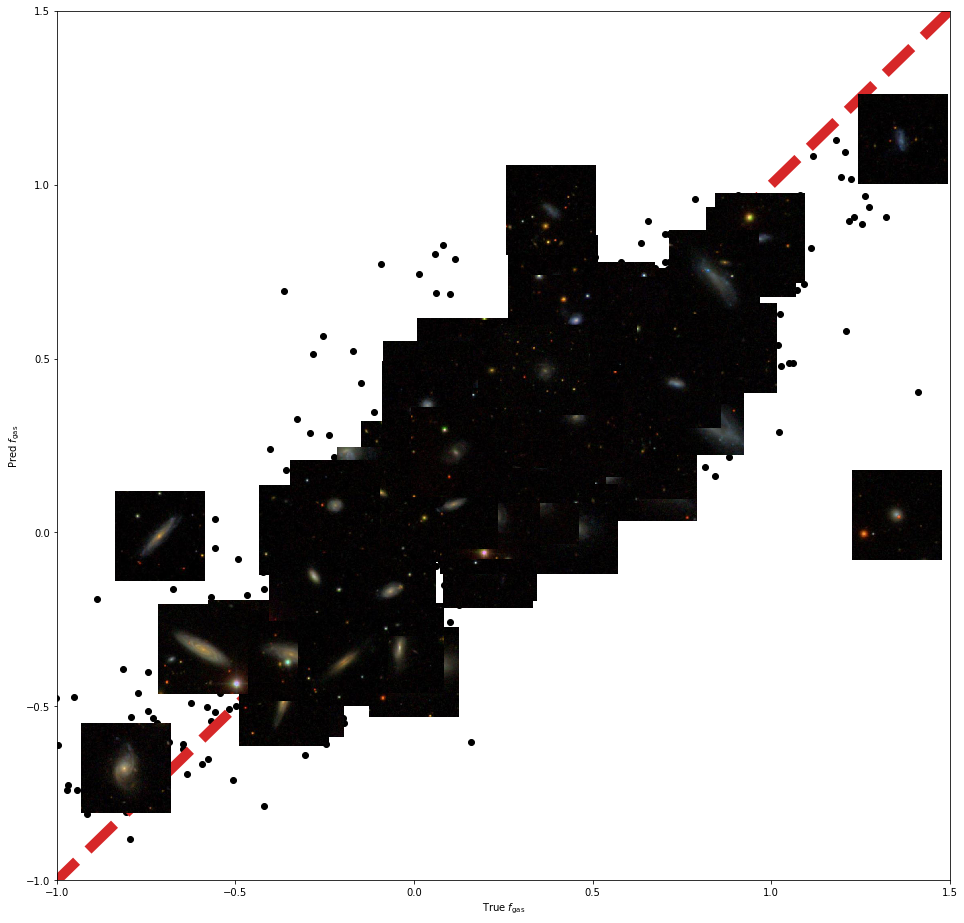

In [0]:
plot_results(results, show_images=True)

In [0]:
learn.save('a.40_xresnet34-ranger_15ep')

# Repeat with more training

In [0]:
df = pd.read_csv(f'{PATH}/data/a40-SDSS_galaxy-properties.csv')

tfms = get_transforms(do_flip=True, flip_vert=True, max_zoom=1., max_rotate=15., max_lighting=0, max_warp=0)

xGASS_stats = [tensor([-0.0169, -0.0105, -0.0004]), tensor([0.9912, 0.9968, 1.0224])]


bs = 64
sz = 224

In [0]:
src = (ImageList.from_df(df, path=PATH, folder='images-OC', suffix='.jpg', cols='AGCNr')
                .split_by_rand_pct(0.2, seed=seed)
                .label_from_df(cols=['logfgas'],  label_cls=FloatList)
      )

data = (src.transform(tfms, size=sz)
            .databunch(bs=bs)
            .normalize(xGASS_stats)
       )

In [0]:
learn = Learner(data, model=models.xresnet34(), 
                opt_func=partial(Ranger),
                loss_func=root_mean_squared_error,
                wd=1e-3, bn_wd=False, true_wd=True,
               )

learn.model[-1] = nn.Linear(512, 1, bias=True).cuda()


set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


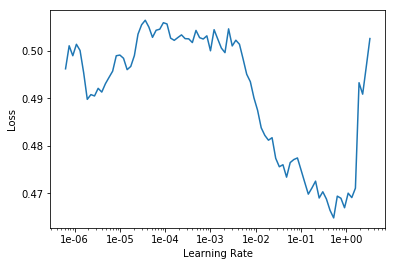

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(40, 3e-2)

epoch,train_loss,valid_loss,time
0,0.432047,0.392543,00:51
1,0.394570,0.362585,00:52
2,0.359303,0.318523,00:51
3,0.317039,0.376802,00:52
4,0.300356,0.299276,00:52
5,0.293394,0.276432,00:52
6,0.294104,0.355342,00:52
7,0.292240,0.300071,00:52
8,0.287030,0.401123,00:52
9,0.282964,0.335111,00:52


# ⭐ Use Mish 

[Mish is a new activation function](https://arxiv.org/abs/1908.08681v1). I'm using the resnet archictecture with Mish included courtesy of [Less Wright](https://github.com/lessw2020/mish)

In [0]:
df = pd.read_csv(f'{PATH}/data/a40-SDSS_galaxy-properties.csv')

tfms = get_transforms(do_flip=True, flip_vert=True, max_zoom=1., max_rotate=15., max_lighting=0, max_warp=0)

xGASS_stats = [tensor([-0.0169, -0.0105, -0.0004]), tensor([0.9912, 0.9968, 1.0224])]


bs = 64
sz = 224

In [0]:
src = (ImageList.from_df(df, path=PATH, folder='images-OC', suffix='.jpg', cols='AGCNr')
                .split_by_rand_pct(0.2, seed=seed)
                .label_from_df(cols=['logfgas'],  label_cls=FloatList)
      )

data = (src.transform(tfms, size=sz)
            .databunch(bs=bs)
            .normalize(xGASS_stats)
       )

In [0]:
learn = Learner(data, model=mxresnet34(), 
                opt_func=partial(Ranger),
                loss_func=root_mean_squared_error,
                wd=1e-3, bn_wd=False, true_wd=True,
               )

learn.model[-1] = nn.Linear(512, 1, bias=True).cuda()


set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


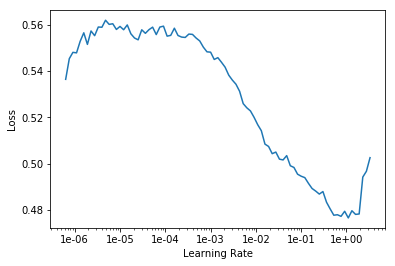

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(15, 6e-2)

epoch,train_loss,valid_loss,time
0,0.365060,0.342881,01:01
1,0.329524,0.383927,01:02
2,0.314874,0.322486,01:01
3,0.305185,0.613341,01:02
4,0.300074,0.300985,01:01
5,0.301814,0.299015,01:01
6,0.294252,0.628197,01:01
7,0.289183,0.537800,01:01
8,0.278531,0.314842,01:01
9,0.278936,0.323731,01:01


In [0]:
fgas_pred, fgas_true = learn.TTA(scale=1.)
root_mean_squared_error(fgas_pred, fgas_true)

tensor(0.2546)

In [0]:
results = pd.DataFrame({'fgas_pred': fgas_pred.squeeze(), 'fgas_true': fgas_true.squeeze()})
results['AGCNr'] = np.array([os.path.basename(fn).strip('.jpg') for fn in data.valid_ds.items])
results.set_index('AGCNr', drop=True, inplace=True)

results.sample(3)

,fgas_pred,fgas_true
AGCNr,,
258422,0.645278,0.987363
202649,0.321013,-0.218964
251098,-0.056520,-0.178010


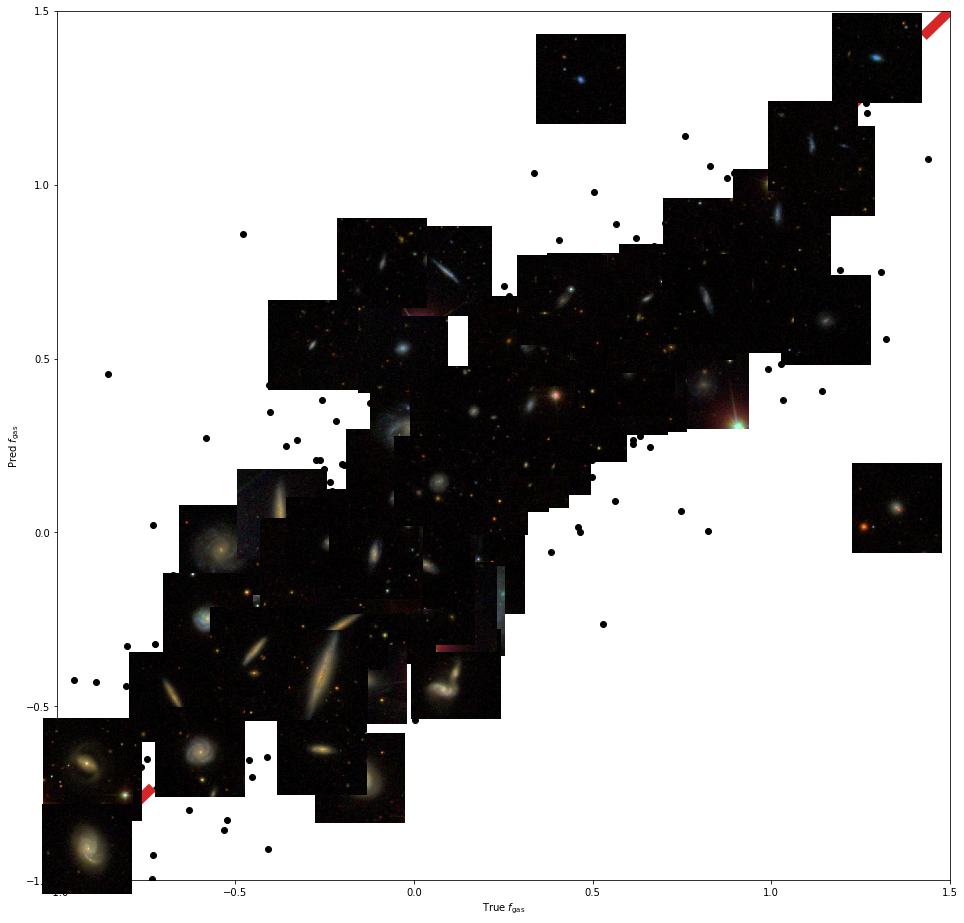

In [0]:
plot_results(results, show_images=True)

In [0]:
learn.save('a.40_xresnet34-ranger-mish_15ep')

## More Mish

In [0]:
df = pd.read_csv(f'{PATH}/data/a40-SDSS_galaxy-properties.csv')

tfms = get_transforms(do_flip=True, flip_vert=True, max_zoom=1., max_rotate=15., max_lighting=0, max_warp=0)

xGASS_stats = [tensor([-0.0169, -0.0105, -0.0004]), tensor([0.9912, 0.9968, 1.0224])]


bs = 32
sz = 224

In [0]:
src = (ImageList.from_df(df, path=PATH, folder='images-OC', suffix='.jpg', cols='AGCNr')
                .split_by_rand_pct(0.2, seed=seed)
                .label_from_df(cols=['logfgas'],  label_cls=FloatList)
      )

data = (src.transform(tfms, size=sz)
            .databunch(bs=bs)
            .normalize(xGASS_stats)
       )

In [0]:
learn = Learner(data, model=mxresnet50(), 
                opt_func=partial(Ranger),
                loss_func=root_mean_squared_error,
                wd=1e-3, bn_wd=False, true_wd=True,
               )

learn.model[-1] = nn.Linear(2048, 1, bias=True).cuda()


In [0]:
learn.fit_one_cycle(40, 3e-2)

epoch,train_loss,valid_loss,time
0,0.376272,0.556313,02:08
1,0.328350,0.392443,02:08
2,0.323051,0.492402,02:08
3,0.308837,0.439164,02:08
4,0.318775,0.515844,02:08
5,0.309783,0.349390,02:08
6,0.310050,0.303822,02:08
7,0.309650,0.295976,02:08
8,0.299334,0.632820,02:08
9,0.300583,0.344610,02:08


In [0]:
# get + plot results
fgas_pred, fgas_true = learn.TTA(scale=1.)
root_mean_squared_error(fgas_pred, fgas_true)

tensor(0.2452)

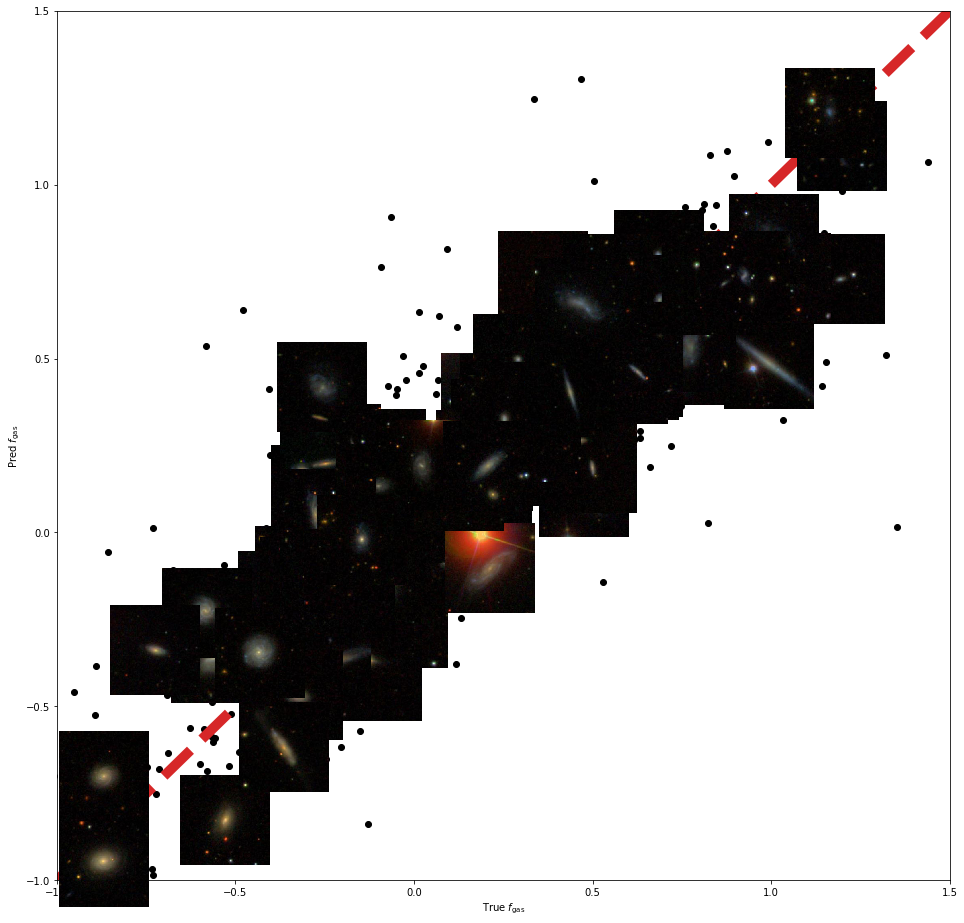

In [0]:
results = pd.DataFrame({'fgas_pred': fgas_pred.squeeze(), 'fgas_true': fgas_true.squeeze()})
results['AGCNr'] = np.array([os.path.basename(fn).strip('.jpg') for fn in data.valid_ds.items])
results.set_index('AGCNr', drop=True, inplace=True)

plot_results(results, show_images=True)

## Even more Mish

In [0]:
df = pd.read_csv(f'{PATH}/data/a40-SDSS_galaxy-properties.csv')

tfms = get_transforms(do_flip=True, flip_vert=True, max_zoom=1., max_rotate=15., max_lighting=0, max_warp=0)

xGASS_stats = [tensor([-0.0169, -0.0105, -0.0004]), tensor([0.9912, 0.9968, 1.0224])]


bs = 32
sz = 224

In [0]:
src = (ImageList.from_df(df, path=PATH, folder='images-OC', suffix='.jpg', cols='AGCNr')
                .split_by_rand_pct(0.2, seed=seed)
                .label_from_df(cols=['logfgas'],  label_cls=FloatList)
      )

data = (src.transform(tfms, size=sz)
            .databunch(bs=bs)
            .normalize(xGASS_stats)
       )

In [0]:
learn = Learner(data, model=mxresnet50(), 
                opt_func=partial(Ranger),
                loss_func=root_mean_squared_error,
                wd=1e-3, bn_wd=False, true_wd=True,
               )

learn.model[-1] = nn.Linear(2048, 1, bias=True).cuda()


In [0]:
learn.fit_one_cycle(100, 3e-2)

epoch,train_loss,valid_loss,time
0,0.377252,0.343213,01:09
1,0.319386,0.323683,01:05
2,0.302486,0.352917,01:06
3,0.300383,0.296813,01:05
4,0.301862,0.316336,01:05
5,0.281754,0.312325,01:05
6,0.290036,0.308390,01:05
7,0.285623,0.271439,01:05
8,0.288306,0.380688,01:05
9,0.282852,0.446179,01:05


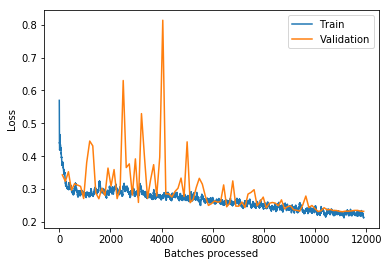

In [0]:
learn.recorder.plot_losses()

In [0]:
learn.export('mxresnet50-ranger_100ep_learner')

In [0]:
fgas_pred, fgas_true = learn.TTA(scale=1.)
root_mean_squared_error(fgas_pred, fgas_true)

tensor(0.2364)

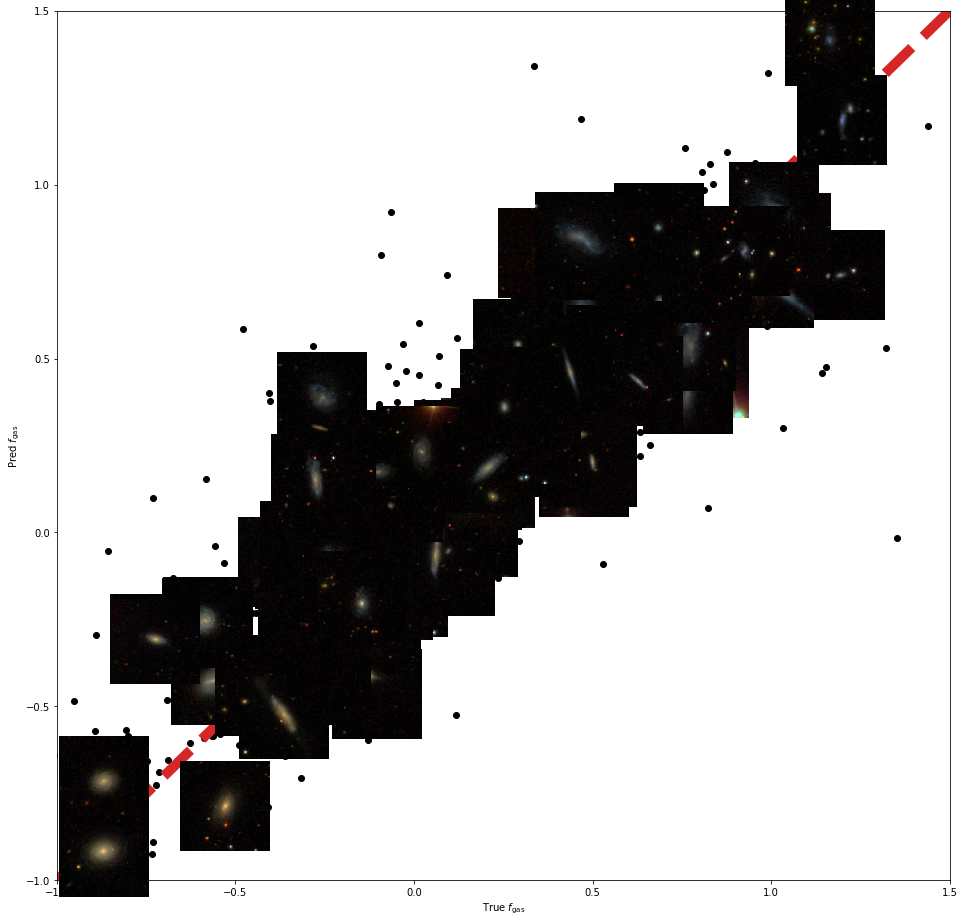

In [0]:
results = pd.DataFrame({'fgas_pred': fgas_pred.squeeze(), 'fgas_true': fgas_true.squeeze()})
results['AGCNr'] = np.array([os.path.basename(fn).strip('.jpg') for fn in data.valid_ds.items])
results.set_index('AGCNr', drop=True, inplace=True)

plot_results(results, show_images=True)

## Try half-precision training

In [0]:
df = pd.read_csv(f'{PATH}/data/a40-SDSS_galaxy-properties.csv')

tfms = get_transforms(do_flip=True, flip_vert=True, max_zoom=1., max_rotate=15., max_lighting=0, max_warp=0)

xGASS_stats = [tensor([-0.0169, -0.0105, -0.0004]), tensor([0.9912, 0.9968, 1.0224])]


bs = 32
sz = 224

In [0]:
src = (ImageList.from_df(df, path=PATH, folder='images-OC', suffix='.jpg', cols='AGCNr')
                .split_by_rand_pct(0.2, seed=seed)
                .label_from_df(cols=['logfgas'],  label_cls=FloatList)
      )

data = (src.transform(tfms, size=sz)
            .databunch(bs=bs)
            .normalize(xGASS_stats)
       )

In [0]:
learn = Learner(data, model=mxresnet18(), 
                opt_func=partial(Ranger),
                loss_func=root_mean_squared_error,
                wd=1e-3, bn_wd=False, true_wd=True,
               )

learn.model[-1] = nn.Linear(512, 1, bias=True).cuda()

In [0]:
learn.to_fp16();

In [0]:
learn.fit_one_cycle(100, slice(3e-2))

epoch,train_loss,valid_loss,time
0,0.400053,0.375420,00:36
1,0.323096,0.299020,00:36
2,0.300298,0.275799,00:36
3,0.292058,0.318205,00:36
4,0.283534,0.274699,00:36
5,0.282709,0.319917,00:36
6,0.287887,0.321682,00:37
7,0.285253,0.593820,00:36
8,0.289936,0.284031,00:36
9,0.280295,0.466548,00:36


In [0]:
learn.to_fp32();

In [0]:
fgas_pred, fgas_true = learn.TTA(scale=1.)
root_mean_squared_error(fgas_pred, fgas_true)

tensor(0.2462)

## With discriminative learning rates

In [0]:
learn = Learner(data, model=mxresnet18(), 
                opt_func=partial(Ranger),
                loss_func=root_mean_squared_error,
                wd=1e-3, bn_wd=False, true_wd=True,
               )

learn.model[-1] = nn.Linear(512, 1, bias=True).cuda()

learn.to_fp16();

In [0]:
learn.fit_one_cycle(100, slice(3e-2,))

epoch,train_loss,valid_loss,time
0,0.411943,0.358962,00:35
1,0.321998,0.423217,00:35
2,0.302395,0.333102,00:35
3,0.273196,0.283251,00:35
4,0.280462,0.293375,00:35
5,0.278990,0.302411,00:35
6,0.282936,0.317404,00:35
7,0.291453,0.305015,00:35
8,0.296334,0.306738,00:35
9,0.286850,0.343654,00:34


## And with a very deep net

In [0]:
learn = Learner(data, model=mxresnet152(), 
                opt_func=partial(Ranger),
                loss_func=root_mean_squared_error,
                wd=1e-3, bn_wd=False, true_wd=True,
               )

learn.model[-1] = nn.Linear(2048, 1, bias=True).cuda()

In [0]:
learn.to_fp16();

In [0]:
learn.fit_one_cycle(100, slice(3e-2))

epoch,train_loss,valid_loss,time
0,0.387516,0.367074,01:18
1,0.332879,0.314767,01:18
2,0.303861,0.367712,01:18
3,0.296646,0.339021,01:18
4,0.293574,0.314650,01:18
5,0.295151,0.270641,01:18
6,0.285373,0.347920,01:18
7,0.296886,0.303166,01:18
8,0.288831,0.302431,01:18
9,0.281063,0.393292,01:18


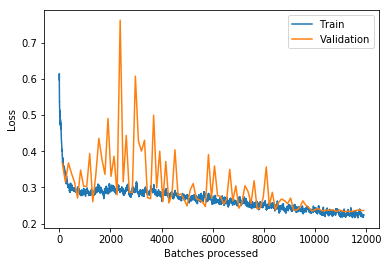

In [0]:
learn.recorder.plot_losses()

In [0]:
learn.to_fp32();

In [0]:
fgas_pred, fgas_true = learn.TTA(scale=1.)
root_mean_squared_error(fgas_pred, fgas_true)

tensor(0.2399)

# Over9000/RangerLars
I originally tried Lars but it doesn't seem to work at the moment. (And the [tests](https://forums.fast.ai/t/meet-mish-new-activation-function-possible-successor-to-relu/53299/27) so far don't seem to show lots of promise.)

However, the Over9000 package makes it easier to use! (results: it's not good for regression.)

In [0]:
df = pd.read_csv(f'{PATH}/data/a40-SDSS_galaxy-properties.csv')

tfms = get_transforms(do_flip=True, flip_vert=True, max_zoom=1., max_rotate=15., max_lighting=0, max_warp=0)

xGASS_stats = [tensor([-0.0169, -0.0105, -0.0004]), tensor([0.9912, 0.9968, 1.0224])]


bs = 64
sz = 224

In [0]:
src = (ImageList.from_df(df, path=PATH, folder='images-OC', suffix='.jpg', cols='AGCNr')
                .split_by_rand_pct(0.2, seed=seed)
                .label_from_df(cols=['logfgas'],  label_cls=FloatList)
      )

data = (src.transform(tfms, size=sz)
            .databunch(bs=bs)
            .normalize(xGASS_stats)
       )

In [0]:
learn = Learner(data, model=mxresnet50(), 
                opt_func=partial(Over9000, betas=(0.9, 0.99), eps=1e-8),
                loss_func=root_mean_squared_error,
                wd=1e-3, bn_wd=False, true_wd=True,
               )

learn.model[-1] = nn.Linear(2048, 1, bias=True).cuda()


In [0]:
learn.fit_one_cycle(40, 1e-2)

# Imbalanced "class" sampling (categorical)?

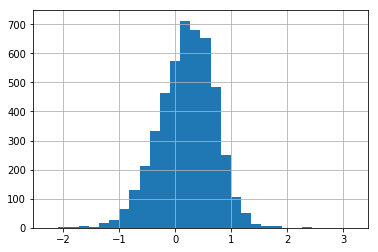

In [0]:
df = pd.read_csv(f'{PATH}/data/a40-SDSS_galaxy-properties.csv')

df.logfgas.hist(bins=30)

In [0]:
bins = np.arange(-2, 2, 0.2)
df['logfgas_cls'] = pd.cut(df.logfgas, bins, labels=(bins[:-1]+0.1).round(1).astype(str))
df.dropna(inplace=True)
df.sample(5)

,Unnamed: 0,AGCNr,DR7ObjID,logMHI,logMstar,logSFR,Zgas,logfgas,logsSFR,logfgas_cls
1597,4510,210073,587732772122591380,10.19,10.447990,0.286254,8.945017,-0.257990,-10.161736,-0.3
2755,7229,224897,587738569780691030,9.16,8.672324,-1.015580,8.331346,0.487676,-9.687904,0.5
1309,3898,205179,587742863667757253,9.39,8.542196,-1.195076,8.195518,0.847804,-9.737272,0.9
4020,10137,9618,587739721376202859,10.15,10.630860,0.796304,9.111057,-0.480860,-9.834555,-0.5
704,2423,190376,587741390498627658,9.50,10.149590,0.219607,9.050574,-0.649590,-9.929984,-0.7


In [0]:
tfms = get_transforms(do_flip=True, flip_vert=True, max_zoom=1., max_rotate=15., max_lighting=0, max_warp=0)

xGASS_stats = [tensor([-0.0169, -0.0105, -0.0004]), tensor([0.9912, 0.9968, 1.0224])]

bs = 64
sz = 224

In [0]:
# now using classes in `logfgas_cls` column
src = (ImageList.from_df(df, path=PATH, folder='images-OC', suffix='.jpg', cols='AGCNr')
                .split_by_rand_pct(0.2, seed=seed)
                .label_from_df(cols=['logfgas_cls'])
      )

data = (src.transform(tfms, size=sz)
            .databunch(bs=bs)
            .normalize(xGASS_stats)
       )

In [0]:
learn = Learner(data, model=mxresnet34(), 
                opt_func=partial(Ranger),
                loss_func=nn.CrossEntropyLoss(),             # or LabelSmoothingCrossEntropy()
                metrics=[accuracy],
                wd=1e-3, bn_wd=False, true_wd=True,
               )

learn.model[-1] = nn.Linear(512, data.c, bias=True).cuda()

In [0]:
# this will help us with undersampling issues
from fastai.callbacks import *

oversampling_cb = OverSamplingCallback(learn)

set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


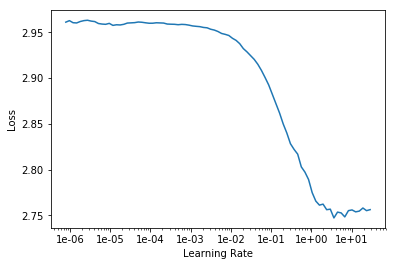

In [0]:
learn.lr_find(end_lr=1e2)
learn.recorder.plot()

Training is significantly slower here than when formulating this as a regression problem. Unfortunately I haven't found a way to get a batchsize larger than `64` here (perhaps I need a dedicated GPU). Another option would be to try a smaller xresnet.

In [0]:
learn.fit_one_cycle(5, 2e-1, callbacks=oversampling_cb)

epoch,train_loss,valid_loss,accuracy,time
0,1.950952,7.364063,0.016719,03:03
1,1.760141,2.416885,0.136886,03:03
2,1.520428,2.062629,0.212121,03:03
3,1.221574,1.896628,0.271682,03:03
4,1.106568,1.806316,0.287356,03:03


In [0]:
tfms = get_transforms(do_flip=True, flip_vert=True, max_zoom=1., max_rotate=15., max_lighting=0, max_warp=0)

xGASS_stats = [tensor([-0.0169, -0.0105, -0.0004]), tensor([0.9912, 0.9968, 1.0224])]

bs = 64
sz = 224

src = (ImageList.from_df(df, path=PATH, folder='images-OC', suffix='.jpg', cols='AGCNr')
                .split_by_rand_pct(0.2, seed=seed)
                .label_from_df(cols=['logfgas_cls'])
      )

data = (src.transform(tfms, size=sz)
            .databunch(bs=bs)
            .normalize(xGASS_stats)
       )

In [0]:
# repeat with label smoothing
learn = Learner(data, model=mxresnet34(), 
                opt_func=partial(Ranger),
                loss_func=LabelSmoothingCrossEntropy(),
                metrics=[accuracy],
                wd=1e-3, bn_wd=False, true_wd=True,
               )

learn.model[-1] = nn.Linear(512, data.c, bias=True).cuda()

In [0]:
learn.fit_one_cycle(5, 2e-1, callbacks=OverSamplingCallback(learn))

epoch,train_loss,valid_loss,accuracy,time
0,2.123620,3.408975,0.042842,03:02
1,1.982592,2.202234,0.229885,03:02
2,1.776987,2.430737,0.165099,03:01
3,1.560937,2.007763,0.317659,03:02
4,1.473748,2.024395,0.299895,03:01


In [0]:
# repeat with higher lr and smaller model
learn = Learner(data, model=mxresnet18(), 
                opt_func=partial(Ranger),
                loss_func=LabelSmoothingCrossEntropy(),
                metrics=[accuracy],
                wd=1e-3, bn_wd=False, true_wd=True,
               )

learn.model[-1] = nn.Linear(512, data.c, bias=True).cuda()

In [0]:
learn.fit_one_cycle(5, 0.5, callbacks=OverSamplingCallback(learn))

epoch,train_loss,valid_loss,accuracy,time
0,2.151924,2.655478,0.108673,02:10
1,1.974175,2.495637,0.177638,02:10
2,1.808204,2.427983,0.167189,02:09
3,1.603198,2.144827,0.241379,02:09
4,1.474276,2.051491,0.289446,02:13


In [0]:
# repeat without oversampling callback
learn = Learner(data, model=mxresnet18(), 
                opt_func=partial(Ranger),
                loss_func=LabelSmoothingCrossEntropy(),
                metrics=[accuracy],
                wd=1e-3, bn_wd=False, true_wd=True,
               )

learn.model[-1] = nn.Linear(512, data.c, bias=True).cuda()

In [0]:
learn.fit_one_cycle(5, 0.5)

epoch,train_loss,valid_loss,accuracy,time
0,2.132481,4.379253,0.007315,02:21
1,1.971247,2.179451,0.223615,02:25
2,1.791973,2.404810,0.166144,02:25
3,1.592176,2.023124,0.308255,02:26
4,1.467015,2.041317,0.301985,02:26


It might make more sense to initially train the base model *without resampling*, and then fine-tune using the oversampled classes. However, the difference isn't too large

# More fine-grained classes

In [0]:
df = pd.read_csv(f'{PATH}/data/a40-SDSS_galaxy-properties.csv')
df.logfgas = df.logfgas.round(1)

df.sample(3)

,Unnamed: 0,AGCNr,DR7ObjID,logMHI,logMstar,logSFR,Zgas,logfgas,logsSFR
3052,7820,232888,588010878767857916,9.05,8.792926,-0.617494,8.558309,0.3,-9.410420
4226,10645,253982,587736546312978790,10.01,9.548105,0.011273,8.809116,0.5,-9.536832
4171,10524,251993,587736546312454552,9.83,10.070880,0.322769,9.067355,-0.2,-9.748111


In [0]:
bins = np.arange(-2.05, 2.05, 0.1)
df['logfgas_cls'] = pd.cut(df.logfgas, bins, labels=(bins[:-1]+0.05).round(1).astype(str))
df.dropna(inplace=True)
df.sample(3)

,Unnamed: 0,AGCNr,DR7ObjID,logMHI,logMstar,logSFR,Zgas,logfgas,logsSFR,logfgas_cls
1531,4348,214174,587728879271542838,9.63,8.824239,-0.611051,8.473251,0.8,-9.435290,0.8
2433,6382,224501,588017704543322125,10.02,9.234223,-0.628261,8.605153,0.8,-9.862484,0.8
2856,7428,232129,588010880376569988,8.95,8.247958,-1.274442,8.168261,0.7,-9.522400,0.7


In [0]:
tfms = get_transforms(do_flip=True, flip_vert=True, max_zoom=1., max_rotate=15., max_lighting=0, max_warp=0)

xGASS_stats = [tensor([-0.0169, -0.0105, -0.0004]), tensor([0.9912, 0.9968, 1.0224])]

bs = 64
sz = 224

src = (ImageList.from_df(df, path=PATH, folder='images-OC', suffix='.jpg', cols='AGCNr')
                .split_by_rand_pct(0.2, seed=seed)
                .label_from_df(cols=['logfgas_cls'])
      )

data = (src.transform(tfms, size=sz)
            .databunch(bs=bs)
            .normalize(xGASS_stats)
       )

In [0]:
data.c

39

In [0]:
learn = Learner(data, model=mxresnet34(), 
                opt_func=partial(Ranger),
                loss_func=nn.CrossEntropyLoss(),
                metrics=[accuracy, top_k_accuracy],
                wd=1e-3, bn_wd=False, true_wd=True,
               )

learn.model[-1] = nn.Linear(512, data.c, bias=True).cuda()

In [0]:
# extra warmup
learn.fit_one_cycle(1, 1e-4, pct_start=1., )

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,3.666448,3.661071,0.068894,0.205637,17:18


set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


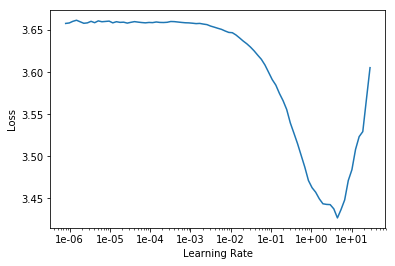

In [0]:
learn.lr_find(end_lr=100)
learn.recorder.plot()


In [0]:
learn.fit_one_cycle(15, 3e-2, callbacks=OverSamplingCallback(learn))

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,5.197583,5.210086,0.074113,0.311065,03:02
1,4.762355,4.917464,0.085595,0.310021,03:05
2,3.713529,4.273222,0.057411,0.327766,03:03
3,2.882992,3.437137,0.089770,0.446764,03:03
4,2.350617,2.790144,0.116910,0.540710,03:05
5,2.071248,4.519904,0.052192,0.332985,03:04
6,1.846694,3.367128,0.085595,0.374739,03:07
7,1.724854,2.827029,0.134656,0.573069,03:06
8,1.620780,2.674328,0.118998,0.630480,03:07
9,1.524083,2.605788,0.144050,0.639875,03:03


In [0]:
learn.save('categorical_bins-0.1_oversampled_mxresnet34-16ep')

In [0]:
# classification interpretation (no TTA)
preds, y, losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)

In [0]:
# this won't work due to incorrect ordering
# interp.plot_confusion_matrix(plot_txt=False, figsize=(12, 12))

In [0]:
# correct ordering
cm = interp.confusion_matrix()

cm[:19, :19] = cm[18::-1, 18::-1]
cm[19:, :19] = cm[19:, 18::-1]
cm[:19, 19:] = cm[18::-1, 19:]

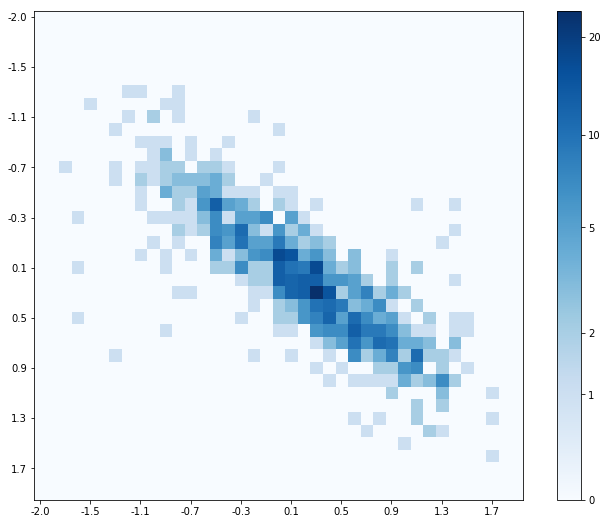

In [0]:
cls_labels = sorted(np.array(data.classes).astype(float))

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111)

im = ax.imshow(np.log10(1+cm), cmap='Blues')
ax.set_xticks(range(data.c)[::4])
ax.set_yticks(range(data.c)[::4])
ax.set_xticklabels(cls_labels[::4])
ax.set_yticklabels(cls_labels[::4])

cb = fig.colorbar(im)
cb.set_ticks(np.log10(1 + np.array([0, 1, 2, 5, 10, 20])))
cb.set_ticklabels([0, 1, 2, 5, 10, 20])

In [0]:
cls_labels

[-2.0,
 -1.8,
 -1.7,
 -1.6,
 -1.5,
 -1.4,
 -1.3,
 -1.2,
 -1.1,
 -1.0,
 -0.9,
 -0.8,
 -0.7,
 -0.6,
 -0.5,
 -0.4,
 -0.3,
 -0.2,
 -0.1,
 0.0,
 0.1,
 0.2,
 0.3,
 0.4,
 0.5,
 0.6,
 0.7,
 0.8,
 0.9,
 1.0,
 1.1,
 1.2,
 1.3,
 1.4,
 1.5,
 1.6,
 1.7,
 1.8,
 1.9]

Continue training!

In [0]:
learn.load('categorical_bins-0.1_oversampled_mxresnet34-16ep');

set state called


set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


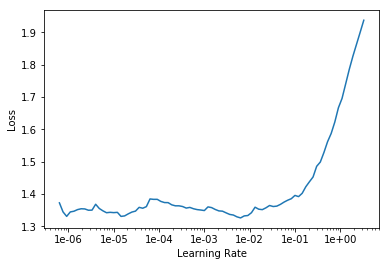

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(15, 1e-3)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,3.158404,3.115679,0.076200,0.406054,03:04
1,3.118176,3.102813,0.077244,0.418580,03:04
2,3.047873,3.055999,0.085595,0.433194,03:04
3,2.973937,2.985131,0.096033,0.451983,03:04
4,2.871369,2.978556,0.102296,0.460334,03:04
5,2.801516,2.940001,0.118998,0.481211,03:04
6,2.777750,2.892105,0.131524,0.494781,03:04
7,2.722469,2.895885,0.126305,0.492693,03:05
8,2.694093,2.850400,0.132568,0.508351,03:04
9,2.670647,2.857544,0.129436,0.502088,03:04


KeyboardInterrupt: ignored

# Train with Over9000/RangerLars and flat+cosine schedule
As proposed by [grankin in the Fastai forums](https://forums.fast.ai/t/imagenette-woof-leaderboards-guidelines-for-proving-new-high-scores/52714/19), flat (75%) + cosine anneal (25%) works well with the `over9000` optimizer (i.e., RAdam + LARS + LookAhead)

In [0]:
def fit_with_annealing(learn:Learner, num_epoch:int, lr:float=defaults.lr, annealing_start:float=0.7)->None:
    """Flat + cosine anneal from @mgrankin experiments"""
    n = len(learn.data.train_dl)
    anneal_start = int(n*num_epoch*annealing_start)
    phase0 = TrainingPhase(anneal_start).schedule_hp('lr', lr)
    phase1 = TrainingPhase(n*num_epoch - anneal_start).schedule_hp('lr', lr, anneal=annealing_cos)
    phases = [phase0, phase1]
    sched = GeneralScheduler(learn, phases)
    learn.callbacks.append(sched)
    learn.fit(num_epoch)

In [0]:
df = pd.read_csv(f'{PATH}/data/a40-SDSS_galaxy-properties.csv')
df.logfgas = df.logfgas.round(1)

bins = np.arange(-2.05, 2.05, 0.1)
df['logfgas_cls'] = pd.cut(df.logfgas, bins, labels=(bins[:-1]+0.05).round(1).astype(str))
df.dropna(inplace=True)

In [0]:
tfms = get_transforms(do_flip=True, flip_vert=True, max_zoom=1., max_rotate=15., max_lighting=0, max_warp=0)

xGASS_stats = [tensor([-0.0169, -0.0105, -0.0004]), tensor([0.9912, 0.9968, 1.0224])]

bs = 64
sz = 224

src = (ImageList.from_df(df, path=PATH, folder='images-OC', suffix='.jpg', cols='AGCNr')
                .split_by_rand_pct(0.2, seed=seed)
                .label_from_df(cols=['logfgas_cls'])
      )

data = (src.transform(tfms, size=sz)
            .databunch(bs=bs)
            .normalize(xGASS_stats)
       )

In [0]:
learn = Learner(data, model=mxresnet34(), 
                opt_func=partial(Over9000),
                loss_func=nn.CrossEntropyLoss(),
                metrics=[accuracy, partial(top_k_accuracy, k=3)],
                wd=1e-3, bn_wd=False, true_wd=True,
               )

learn.model[-1] = nn.Linear(512, data.c, bias=True).cuda()

In [0]:
fit_with_annealing(learn, 15, 3e-2, annealing_start=0.7)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,3.434244,3.202678,0.096033,0.297495,01:08
1,3.174713,3.193415,0.070981,0.221294,01:08
2,3.000053,2.929254,0.096033,0.276618,01:08
3,2.892982,2.940373,0.088727,0.271399,01:09
4,2.834375,3.287323,0.083507,0.205637,01:09
5,2.771365,2.677501,0.141962,0.395616,01:08
6,2.725739,3.161220,0.073069,0.234864,01:09
7,2.659499,4.091626,0.046973,0.150313,01:09
8,2.604871,2.740785,0.114823,0.343424,01:09
9,2.544713,3.321516,0.118998,0.354906,01:08


Repeat with `Over9000` optimizer but with `fit_one_cycle` schedule (begin annealing at 70%)

In [0]:
learn = Learner(data, model=mxresnet34(), 
                opt_func=partial(Over9000),
                loss_func=nn.CrossEntropyLoss(),
                metrics=[accuracy, partial(top_k_accuracy, k=3)],
                wd=1e-3, bn_wd=False, true_wd=True,
               )

learn.model[-1] = nn.Linear(512, data.c, bias=True).cuda()

In [0]:
learn.fit_one_cycle(15, 3e-2, pct_start=0.7)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,3.641891,3.635232,0.037578,0.134656,01:08
1,3.561245,3.428644,0.081420,0.293319,01:08
2,3.452031,3.160455,0.086639,0.283925,01:08
3,3.298572,3.080365,0.103340,0.325678,01:09
4,3.142078,3.044066,0.086639,0.290188,01:09
5,3.004120,3.065123,0.105428,0.275574,01:08
6,2.908354,3.473377,0.025052,0.153445,01:08
7,2.845578,3.041234,0.103340,0.314196,01:09
8,2.809326,4.255265,0.113779,0.264092,01:09
9,2.772151,2.885571,0.131524,0.359081,01:09


Repeat one-cycle again but begin annealing at 30% as usual

In [0]:
learn = Learner(data, model=mxresnet34(), 
                opt_func=partial(Over9000),
                loss_func=nn.CrossEntropyLoss(),
                metrics=[accuracy, partial(top_k_accuracy, k=3)],
                wd=1e-3, bn_wd=False, true_wd=True,
               )

learn.model[-1] = nn.Linear(512, data.c, bias=True).cuda()

learn.fit_one_cycle(15, 3e-2, pct_start=0.3)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,3.604385,3.577234,0.103340,0.221294,01:08
1,3.447582,3.432910,0.087683,0.235908,01:08
2,3.222390,3.422007,0.076200,0.210856,01:08
3,3.041801,3.983513,0.096033,0.267223,01:08
4,2.924747,3.370310,0.061587,0.184760,01:09
5,2.854844,2.925352,0.099165,0.307933,01:09
6,2.794426,3.800689,0.081420,0.219207,01:09
7,2.737561,4.354338,0.061587,0.168058,01:09
8,2.681895,3.907749,0.082463,0.248434,01:09
9,2.634496,3.925198,0.048017,0.163883,01:09


## Re-run using RangerLars/Over9000
And another re-run of the flat+annealing but with higher rate (and lower `eps=1e-8` rather than `1e-6`)

In [0]:
learn = Learner(data, model=mxresnet34(), 
                opt_func=partial(Over9000, betas=(0.9, 0.99), eps=1e-8),
                loss_func=nn.CrossEntropyLoss(),
                metrics=[accuracy, partial(top_k_accuracy, k=3)],
                wd=1e-3, bn_wd=False, true_wd=True,
               )

learn.model[-1] = nn.Linear(512, data.c, bias=True).cuda()

fit_with_annealing(learn, 40, 3e-2, annealing_start=0.7)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,3.317124,3.717836,0.063674,0.230689,01:10
1,3.046910,3.125746,0.105428,0.244259,01:10
2,2.930161,3.536693,0.056367,0.212944,01:10
3,2.831831,3.108614,0.099165,0.274530,01:10
4,2.783773,2.757979,0.113779,0.291232,01:10
5,2.745902,2.654378,0.123173,0.341336,01:11
6,2.687267,3.742958,0.094990,0.275574,01:11
7,2.615342,2.785730,0.143006,0.381002,01:11
8,2.561088,3.282051,0.122129,0.341336,01:11
9,2.514883,4.068394,0.083507,0.198330,01:11
